In [19]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

np.random.seed(1337)
from timeit import timeit

import matplotlib
import matplotlib.pyplot as plt

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}


def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)

def error_plot3(ys1, ys2, ys3, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys1)), ys1, **kwargs, label='GD')
    plt.plot(range(len(ys2)), ys2, **kwargs, label='Newton')
    plt.plot(range(len(ys3)), ys3, **kwargs, label='BFGS')
    plt.legend()

def error_plot2(ys1, ys2, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys1)), ys1, **kwargs, label='GD')
    plt.plot(range(len(ys2)), ys2, **kwargs, label='Newton')
    plt.legend()

def convergence_plot(fs, gs):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Convergence in objective')    
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.plot(range(len(fs)), fs, **kwargs)
    plt.subplot(122)
    plt.title('Convergence in domain')    
    plt.xlabel('Step')
    plt.yscale('log')
    plt.plot(range(len(gs)), gs, **kwargs)
    plt.tight_layout()


def setup_layout():
    display(HTML(open('custom.html').read()))
    matplotlib.rc('font', **font)

    

### Solving linear regression with Newton's method

**Purpose of this demo**: Motivate alternatives of gradient descent

+ Disclaimer: I'm not expert in Python - I use Python/Matlab as tools to validate algorithms and theorems. 
+ Thus, my implementations are not the most efficient ones + there might be bugs

**Problem definition: Linear regression**. 

\begin{align}
  y = A x^\star
\end{align}

+ $A \in \mathbb{R}^{n \times n}$
+ $x^\star \in \mathbb{R}^n$

Assume $A$ is in general position.
Given $y$ and $A$:

\begin{equation*}
\begin{aligned}
& \underset{x \in \mathbb{R}^p}{\text{min}}
& & f(x) \triangleq \|y - A x\|_2^2 \\
\end{aligned}
\end{equation*}

+ We want to solve this problem with Newton's method

\begin{align}
x_{t+1} = x_t - \eta \left(\nabla^2 f(x_t) \right)^{-1} \nabla f(x_t)
\end{align}

+ What is the gradient and Hessian of this function?

\begin{align}
\nabla f(x) = -A^\top \left(y - Ax\right) \in \mathbb{R}^n
\end{align}

and
\begin{align}
\nabla^2 f(x) = A^\top A \in \mathbb{R}^{n \times n}
\end{align}

+ Assuming that $A$ is in general position, $A^\top A$ is full rank

+ Let us use the above in Newton's iteration
+ Assuming $x_0$ is zero (initial point), and the step size is $\eta = 1$, then

\begin{align}
x_1 = x_0 - \left(\nabla^2 f(x_0) \right)^{-1} \nabla f(x_0) = - (A^\top A)^{-1} (- A^\top y) = (A^\top A)^{-1} A^\top y
\end{align}

+ Does this solution ring a bell?

#### Questions on Newton's method for linear regression

+ What about underdetermined linear systems?
+ What is the complexity of running Newton's method in well-conditioned linear systems?

\begin{align}
O\left( \log \frac{1}{\varepsilon} \cdot n^2 \right) \quad \quad \text{vs} \quad \quad O \left(n^3\right)
\end{align}

### Logistic regression with quasi-Newton methods

We will solve the logistic regression problem using second-order and quasi-second-order methods, and compare them with first order methods, such as plain gradient descent.

Let's first redefine the sigmoid function:

In [20]:
def sigmoid(x):
    """Sigmoid function."""
    return 1./(1.+np.exp(-x))

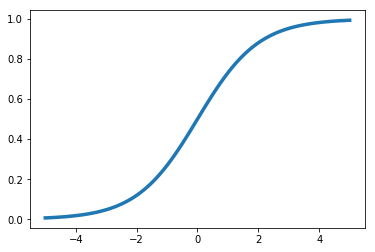

In [21]:
xs = np.linspace(-5, 5, 100)
plt.plot(xs, sigmoid(xs), **kwargs);

In [22]:
def logistic_model(weights, data):
    return sigmoid(data.dot(weights))

def log_likelihood(weights, data, labels):
    scores = np.dot(data, weights)
    return -np.mean(labels*scores - np.log(1 + np.exp(scores)))

def log_likelihood_gradient(weights, data, labels):
    predictions = logistic_model(weights, data)  
    return -data.T.dot(labels - predictions)/len(data)

def log_likelihood_hessian(weights, data, labels):
    predictions = logistic_model(weights, data)
    diag = np.diag(predictions * (1 - predictions))
    return data.T.dot(diag.dot(data))/len(data)

In [23]:
m, n = 1000, 100
data = np.random.normal(0, 1, (m, n))
wopt = np.random.normal(0, 1, n)
labels = (data.dot(wopt) > 0).astype(np.float)
gradient = lambda w: log_likelihood_gradient(w, data, labels)
hessian = lambda w: log_likelihood_hessian(w, data, labels)
init = np.zeros(n)

In [24]:
import sklearn.linear_model as linear_model

In [25]:
cls = linear_model.LogisticRegression()
cls.fit(data, labels)
weights = np.reshape(cls.coef_, cls.coef_.shape[1])
baseline = log_likelihood(weights, data, labels)
baseline

0.05166262561432568

In [26]:
def gradient_descent(init, step_sizes, grad):    
    X = [init]
    for step in step_sizes:
        X.append(X[-1] - step * grad(X[-1]))
    return X

In [27]:
def newton_descent(init, step_sizes, grad, hessian):
    X = [init]
    for step in step_sizes:
        Hinv = np.linalg.pinv(hessian(X[-1]))
        X.append(X[-1] - step * Hinv.dot(grad(X[-1])))
    return X

In [28]:
ws_gd = gradient_descent(init, np.ones(200), gradient)
ws_newton = newton_descent(init, np.ones(200), gradient, hessian)

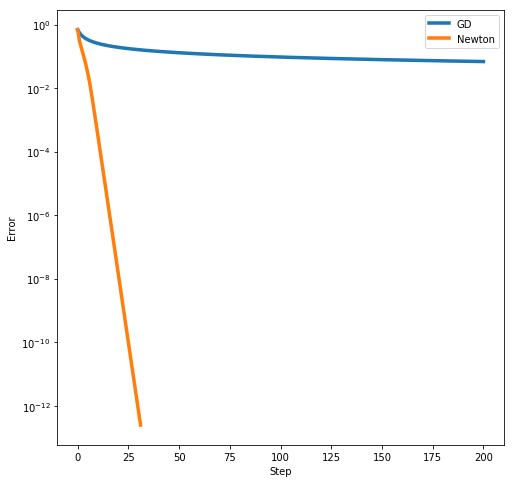

In [29]:
error_plot2([log_likelihood(w, data, labels) for w in ws_gd], 
            [log_likelihood(w, data, labels) for w in ws_newton])

### Using BFGS in logistic regression

In [30]:
def bfgs(init, grad, hessian, line_search, num_steps, num_to_keep=None):
    """BFGS algorithm (toy implementation).
    
    Parameters
    ----------
        initial : array
            starting point
        grad : function
            mapping arrays to arrays of same shape
        hessian : function
            mapping 1d arrays to 2d arrays
        line_search : function
            method to determine step size
        num_steps : number
            number of iterations
        num_to_keep : integer, optional
            number of points to keep
        
    Returns
    -------
        List of points computed by Newton iteration. Length of the
        list is determined by `num_to_keep`.
    """
    xs = [init]
    I = np.eye(len(init))
    Hs = [hessian(init)]
    Hinvs = [I]
    
    for _ in range(num_steps):
        # update point
        direction = Hinvs[-1].dot(grad(xs[-1]))
        step = line_search(xs[-1], direction)
        xs.append(xs[-1] + step * direction)
        
        s = xs[-1] - xs[-2]
        y = grad(xs[-1]) - grad(xs[-2])
        ys = np.dot(y, s)
        ssT = np.outer(s, s)
        
        # udpate H
        H = Hs[-1] + np.outer(y, y)/ys
        H -= Hs[-1].dot(ssT.dot(Hs[-1]))/np.dot(s, Hs[-1].dot(s))
        Hs.append(H)
        
        # update Hinv
        left = I - np.outer(s, y)/ys
        right = I - np.outer(y, s)/ys
        Hinvs.append(left.dot(Hinvs[-1]).dot(right) + ssT/ys)
        
        if num_to_keep:
          xs = xs[-num_to_keep:]
    
    return xs

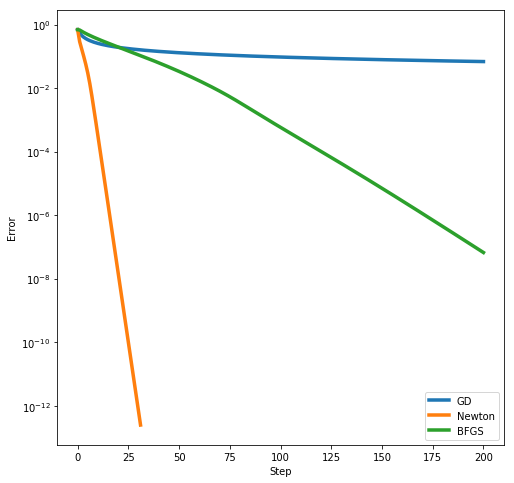

In [32]:
def line_search(x, d):
    """Constant step size."""
    return -0.1

ws_bfgs = bfgs(init, gradient, hessian, line_search, 200)

error_plot3([log_likelihood(w, data, labels) for w in ws_gd], 
            [log_likelihood(w, data, labels) for w in ws_newton],
            [log_likelihood(w, data, labels) for w in ws_bfgs])

# error_plot([log_likelihood(w, data, labels) for w in ws_bfgs])
# plt.plot(range(len(ws_bfgs)), [baseline]*len(ws_bfgs),
#         label='sklearn', **kwargs)
# _ = plt.legend()